In [1]:
# import packages
using LinearAlgebra, HDF5, Interpolations, DataFrames

push!(LOAD_PATH,"../") #path to HF0d.jl
using HF0d

#set up plotting
using PyPlot
function remove_extra_borders!(contourlines)
    for c in contourlines.collections
        c.set_edgecolor("face")
    end
end

#color palettes --- just for aesthetics
using ColorSchemes
cmap = colorschemes[:balance]
rgbtotuple(c) = (c.r,c.g,c.b)
pal = rgbtotuple.(colorschemes[:Set1_9]);

# Density of States Profile

In [2]:
N=100000 #large number of points to resolve the peak, but doesn't affect HF much
hfm = HF0d.HFmodel_supermoire(N; Umm=28,Umsm=28,Usmsm=0,W1=20,W2=5,δ=0.075);

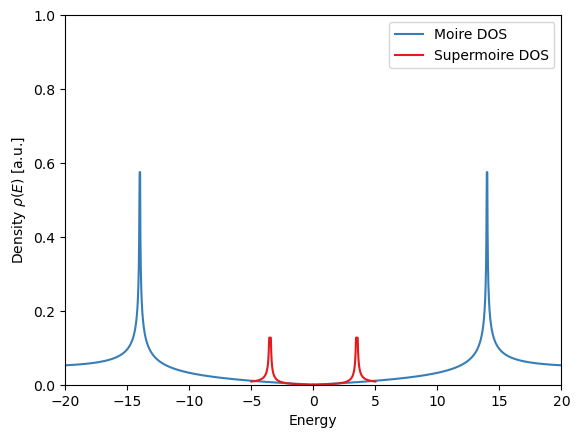

PyObject <matplotlib.legend.Legend object at 0x2a52f48b0>

In [3]:
PyPlot.svg(true)

plot(hfm.ϵs[1],hfm.ρs[1],color=pal[2],label="Moire DOS")
plot(hfm.ϵs[5],hfm.ρs[5],color=pal[2])

plot(hfm.ϵs[9],hfm.ρs[9],color=pal[1],label="Supermoire DOS")
plot(hfm.ϵs[13],hfm.ρs[13],color=pal[1])

xlim(-20,20)
ylim(0,1)


# title("Moire and Supermoire Kinetic DOS")
xlabel("Energy")
ylabel(L"Density $\rho(E)$ [a.u.]")
legend()

# Figure 2 Compressibility

In [4]:
# μs = -150:1:150 #FAST --- wide spacing
μs = -150:0.25:150 #SLOW --- fine spacing used in the paper 
dat0 = run_supermoire_model(;
        Umm=28,Umsm=28,Usmsm=0,
        W1=20,W2=5,δ=0.075,
        N=1000, repeats=12,
        μs = μs,        
        save_all_species=true);

Running HF (0D). 


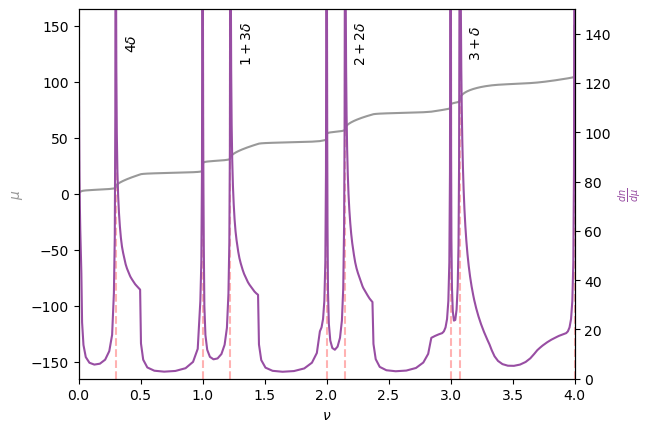

(0.0, 4.0)

In [5]:
PyPlot.svg(true)
fig = figure()
plot(dat0["nus"], dat0["mus"][1:end-1],color=pal[9])
δ=0.075
for x in [0,1,2,3,4, 0+4*δ, 1+3*δ,2+2*δ,3+δ]
    axvline(x,color=(1,0,0,0.3),ls="--",zorder=-1)
end

ycoord = 125
text(0+5*δ,ycoord+10,L"$4\delta$",rotation=90,va="center")
text(1+4*δ,ycoord+10,L"$1+3\delta$",rotation=90,va="center")
text(2+3*δ,ycoord+10,L"$2+2\delta$",rotation=90,va="center")
text(3+2*δ,ycoord+10,L"$3+\delta$",rotation=90,va="center")

xlabel(L"$\nu$")
ylabel(L"$\mu$",color=pal[9])

axt = gca().twinx()
axt.plot(dat0["nus"], 1 ./ dat0["kappas"],color=pal[4])
axt.set_ylabel(L"$\frac{dn}{d\mu}$",color=pal[4])
axt.set_ylim(0,5)

ylim(0,150)
xlim(0,4)

### Plot data in the style of Fig 2.

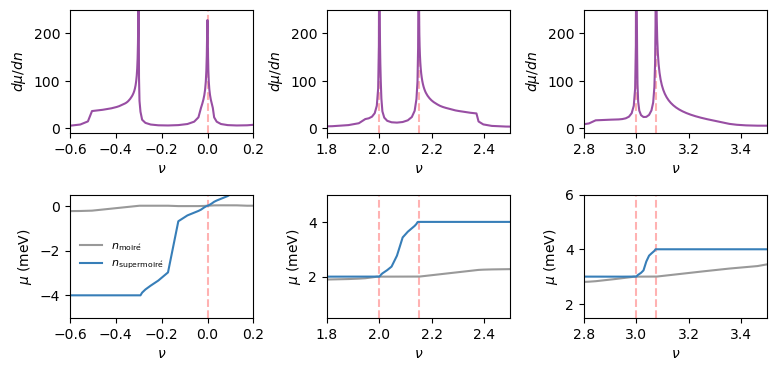

In [6]:
PyPlot.svg(true)
fig, axs = subplots(2,3,figsize=(9,4))

#translate fillings to occupations
ns_moire =  dropdims(mapslices(sum,dat0["nus_all"][1:8,:],dims=1),dims=1)[1:end-1]/(1-δ) .-4
ns_supermoire =  dropdims(mapslices(sum,dat0["nus_all"][9:end,:],dims=1),dims=1)[1:end-1]/(δ) .- 4


δ=0.075
xs = [ [-0.6,0.2], [1.8,2.5], [2.8,3.5] ]
ys = [ [-5,0.5], [0.5,5],[1.5,6]]

for col in [1,2,3]
    sca(axs[1,col])
    plot(dat0["nus"], 1 ./ dat0["kappas"],"-",color=pal[4])
    for n in 0:4
        axvline(n,color=(1,0,0,0.3),ls="--",zorder=-1)
        axvline(n+(4-n)*δ,color=(1,0,0,0.3),ls="--",zorder=1)
    end

    xlabel(L"$\nu$")
    ylabel(L"$d \mu/dn$")
    ylim(-10,250)
    xlim(xs[col])

    #occuptions
    sca(axs[2,col])
    plot(dat0["nus"],ns_moire,label=L"$n_{\mathrm{moir\'e}}$",color=pal[9])
    plot(dat0["nus"],ns_supermoire,label=L"$n_{\mathrm{supermoir\'e}}$",color=pal[2])

    for n in 0:4
        axvline(n,color=(1,0,0,0.3),ls="--",zorder=-1)
        axvline(n+(4-n)*δ,color=(1,0,0,0.3),ls="--",zorder=1)
    end

    xlabel(L"$\nu$")
    ylabel(L"$\mu$ (meV)")
    ylim(ys[col])
    xlim(xs[col])
    col == 1 && legend(frameon=false,fontsize=8)
end

fig.subplots_adjust(wspace=0.4,hspace=0.5)

# Tune $W_{sm}/W_m$ 

### Generate Data and Save to HDF5 for archiving

- Takes about 10 minutes on a modern laptop.
- Decrease the size of $\mu$ steps to speed up.
- For multithreading, follow instructions at
 https://julialang.github.io/IJulia.jl/stable/manual/installation/

In [7]:
folder = "data_Wsm_scan"
isdir(folder) || mkdir(folder) #make the directory if it doesn't exist already
#list of W2s
W2s = 1:20
# μs = 0:1:150 #FAST --- wide spacing
μs = 0:0.25:150 #SLOW --- fine spacing used in the paper 
generate_Wsm_scan_data(folder, W2s, μs)

6
Running HF (0D). 
Running HF (0D). 
Running HF (0D). 
Running HF (0D). 
Running HF (0D). 
Running HF (0D). 
μ = 2.25 (10/601)
μ = 4.75 (20/601)
μ = 2.25 (10/601)
μ = 2.25 (10/601)
μ = 4.75 (20/601)
μ = 2.25 (10/601)
μ = 4.75 (20/601)
μ = 7.25 (30/601)
μ = 2.25 (10/601)
μ = 7.25 (30/601)
μ = 7.25 (30/601)
μ = 9.75 (40/601)
μ = 2.25 (10/601)
μ = 4.75 (20/601)
μ = 4.75 (20/601)
μ = 9.75 (40/601)
μ = 4.75 (20/601)
μ = 9.75 (40/601)
μ = 7.25 (30/601)
μ = 7.25 (30/601)
μ = 7.25 (30/601)
μ = 12.25 (50/601)
μ = 9.75 (40/601)
μ = 9.75 (40/601)
μ = 12.25 (50/601)
μ = 9.75 (40/601)
μ = 12.25 (50/601)
μ = 12.25 (50/601)
μ = 14.75 (60/601)
μ = 12.25 (50/601)
μ = 12.25 (50/601)
μ = 14.75 (60/601)
μ = 17.25 (70/601)
μ = 14.75 (60/601)
μ = 19.75 (80/601)
μ = 22.25 (90/601)
μ = 17.25 (70/601)
μ = 24.75 (100/601)
μ = 14.75 (60/601)
μ = 19.75 (80/601)
μ = 27.25 (110/601)
μ = 17.25 (70/601)
μ = 22.25 (90/601)
μ = 14.75 (60/601)
μ = 24.75 (100/601)
μ = 17.25 (70/601)
μ = 27.25 (110/601)
μ = 19.75 (80/601

### Load data and turn it into a dataframe for convenience

In [8]:
folder = "data_Wsm_scan/"
files = filter(endswith(".h5"), folder .* readdir(folder))
@show files

df = process_raw_data_files_to_dataframe(files, verbose=false);
sort!(df,:W2)
size(df,1)

files = ["data_Wsm_scan/dat_W2_1.h5", "data_Wsm_scan/dat_W2_10.h5", "data_Wsm_scan/dat_W2_11.h5", "data_Wsm_scan/dat_W2_12.h5", "data_Wsm_scan/dat_W2_13.h5", "data_Wsm_scan/dat_W2_14.h5", "data_Wsm_scan/dat_W2_15.h5", "data_Wsm_scan/dat_W2_16.h5", "data_Wsm_scan/dat_W2_17.h5", "data_Wsm_scan/dat_W2_18.h5", "data_Wsm_scan/dat_W2_19.h5", "data_Wsm_scan/dat_W2_2.h5", "data_Wsm_scan/dat_W2_20.h5", "data_Wsm_scan/dat_W2_3.h5", "data_Wsm_scan/dat_W2_4.h5", "data_Wsm_scan/dat_W2_5.h5", "data_Wsm_scan/dat_W2_6.h5", "data_Wsm_scan/dat_W2_7.h5", "data_Wsm_scan/dat_W2_8.h5", "data_Wsm_scan/dat_W2_9.h5"]


20

### Linear Interpolation

To display as an image, we need evenly spaced $\nu$'s, but
the data has evenly spaced $\mu$'s. To convert, we make a linear interpolation
$$
\kappa(\nu)
$$
from the data $(\kappa_n, \nu(\mu_n) )$ and sample it at 20,00 evenly spaced points $\nu_n$.

In [9]:
νs_all = df[!,:nus];
κs_all = df[!,:kappas]
W2s = df[!,:W2]
νs_interp = range(0.0,4.0,length=2000)
κs_interp = []
for (νs,κs) in zip(νs_all,κs_all)
    p = sortperm(νs)
    itp = linear_interpolation(νs[p], κs[p],extrapolation_bc=Interpolations.Line())
    κs0 = itp.(νs_interp)
    push!(κs_interp,κs0)
end
dmudn_interp = 1 ./ stack(κs_interp);

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    600-element Vector{Float64}:
│     0.0008719158771537394
│     0.0019639690497657014
│     0.00387607453574379
│     0.007014932331832036
│     0.012721287067257947
│     ⋮
│     3.9999999998728493
│     3.9999999998741167
│     3.9999999998741336
│     3.99999999987737
│     3.9999999998778426
└ @ Interpolations ~/.julia/packages/Interpolations/91PhN/src/gridded/gridded.jl:77


### Plot Inverse Compressibility

Aesthetic notes: use the same color scheme as the SET data. Cut off the divergences in $d\mu/dn$ at 100 a.u.

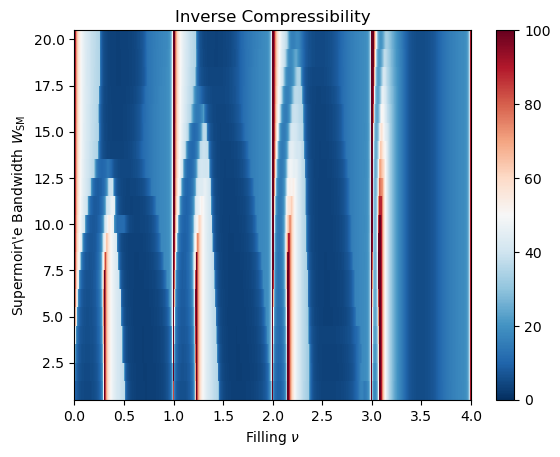

PyObject Text(0.5, 1.0, 'Inverse Compressibility')

In [10]:
PyPlot.svg(false)
pcolormesh(νs_interp, W2s, dmudn_interp',vmin=0,vmax=100,cmap="RdBu_r")
cb = colorbar()

xlabel(L"Filling $\nu$")
ylabel(L"Supermoir\'e Bandwidth $W_{\mathrm{SM}}$")
title("Inverse Compressibility")
# savefig("inverse_compressibilty_versus_sm_Bandwidth.png")

### Export in Matlab format for Y.X.

In [11]:
using MAT #package for matlab format IO
matwrite("supermore_model_W_sm_scan_data.mat", Dict(
    "W_sm" => df[!,:W2],
    "W_m" => df[!,:W1],
    "V_m_m" => df[!,:Umm],
    "V_m_sm" => df[!,:Umsm] .* δ,
    "V_sm_sm" => df[!,:Usmsm],
	"U_m_m" => df[!,:Umm],
    "U_m_sm" => df[!,:Umsm],
    "U_sm_sm" => df[!,:Usmsm],
	"nus_interpolated" => collect(νs_interp),
    "dmu_dn_interpolated" => dmudn_interp,
    "nus" => df[!,:nus_all],
    "nus_total" => df[!,:nus]
); compress = true)

# Tune $U_m/W_m$

- Takes about 10 minutes on a modern laptop.
- Decrease the size of $\mu$ steps to speed up.
- For multithreading, follow instructions at
 https://julialang.github.io/IJulia.jl/stable/manual/installation/

In [12]:
folder = "data_Um_scan"
isdir(folder) || mkdir(folder) #make the directory if it doesn't exist already
#select a few to avoid convergence issues
Umms = [0.0, 8.0, 10.0, 14.0, 16.0, 20.0, 26.0, 28.0, 38.0, 40.0, 42.0, 44.0, 46.0, 48.0, 50.0, 52.0, 54.0, 56.0, 58.0, 60.0]
# μs = 0:1:150 #FAST --- wide spacing
μs = 0:0.25:150 #SLOW --- fine spacing used in the paper 
generate_Um_scan_data(folder, Umms, μs)

6
Running HF (0D). 
Running HF (0D). 
Running HF (0D). 
Running HF (0D). 
Running HF (0D). 
Running HF (0D). 
μ = 2.25 (10/601)
μ = 2.25 (10/601)
μ = 2.25 (10/601)
μ = 4.75 (20/601)
μ = 2.25 (10/601)
μ = 4.75 (20/601)
μ = 4.75 (20/601)
μ = 2.25 (10/601)
μ = 7.25 (30/601)
μ = 2.25 (10/601)
μ = 4.75 (20/601)
μ = 7.25 (30/601)
μ = 7.25 (30/601)
μ = 4.75 (20/601)
μ = 7.25 (30/601)
μ = 9.75 (40/601)
μ = 9.75 (40/601)
μ = 7.25 (30/601)
μ = 9.75 (40/601)
μ = 9.75 (40/601)
μ = 12.25 (50/601)
μ = 12.25 (50/601)
μ = 4.75 (20/601)
μ = 14.75 (60/601)
μ = 12.25 (50/601)
μ = 14.75 (60/601)
μ = 9.75 (40/601)
μ = 17.25 (70/601)
μ = 12.25 (50/601)
μ = 19.75 (80/601)
μ = 22.25 (90/601)
μ = 14.75 (60/601)
μ = 17.25 (70/601)
μ = 24.75 (100/601)
μ = 7.25 (30/601)
μ = 27.25 (110/601)
μ = 29.75 (120/601)
μ = 32.25 (130/601)
μ = 34.75 (140/601)
μ = 17.25 (70/601)
μ = 37.25 (150/601)
μ = 39.75 (160/601)
μ = 42.25 (170/601)
μ = 19.75 (80/601)
μ = 44.75 (180/601)
μ = 12.25 (50/601)
μ = 47.25 (190/601)
μ = 49.75 

In [13]:
folder = "data_Um_scan/"
files = filter(endswith(".h5"), folder .* readdir(folder))
@show files

df = process_raw_data_files_to_dataframe(files, verbose=false);
sort!(df,:Umm)
df[!,:Um_Wm_ratio] = df.Umm ./ df.W1;
size(df,1)

files = ["data_Um_scan/dat_Um_0.0.h5", "data_Um_scan/dat_Um_10.0.h5", "data_Um_scan/dat_Um_14.0.h5", "data_Um_scan/dat_Um_16.0.h5", "data_Um_scan/dat_Um_20.0.h5", "data_Um_scan/dat_Um_26.0.h5", "data_Um_scan/dat_Um_28.0.h5", "data_Um_scan/dat_Um_38.0.h5", "data_Um_scan/dat_Um_40.0.h5", "data_Um_scan/dat_Um_42.0.h5", "data_Um_scan/dat_Um_44.0.h5", "data_Um_scan/dat_Um_46.0.h5", "data_Um_scan/dat_Um_48.0.h5", "data_Um_scan/dat_Um_50.0.h5", "data_Um_scan/dat_Um_52.0.h5", "data_Um_scan/dat_Um_54.0.h5", "data_Um_scan/dat_Um_56.0.h5", "data_Um_scan/dat_Um_58.0.h5", "data_Um_scan/dat_Um_60.0.h5", "data_Um_scan/dat_Um_8.0.h5"]


20

### Linear Interpolation (Again)

To display as an image, we need evenly spaced $\nu$'s, but
the data has evenly spaced $\mu$'s. To convert, we make a linear interpolation
$$
\kappa(\nu)
$$
from the data $(\kappa_n, \nu(\mu_n) )$ and sample it at 20,00 evenly spaced points $\nu_n$.

In [14]:
νs_all = df[!,:nus];
κs_all = df[!,:kappas]
UmWm_ratio = df[!,:Um_Wm_ratio]
νs_interp = range(0.0,4.0,length=2000)
κs_interp = []
for (νs,κs) in zip(νs_all,κs_all)
    p = sortperm(νs)
    itp = linear_interpolation(νs[p], κs[p],extrapolation_bc=Interpolations.Line())
    κs0 = itp.(νs_interp)
    push!(κs_interp,κs0)
end
dmudn_interp = 1 ./ stack(κs_interp);

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    600-element Vector{Float64}:
│     0.0005512354694605648
│     0.001238086076310374
│     0.0024114024213419682
│     0.004206198064306221
│     0.00674532171930764
│     ⋮
│     3.999999999872581
│     3.999999999873639
│     3.999999999879292
│     3.999999999880039
│     3.999999999882319
└ @ Interpolations ~/.julia/packages/Interpolations/91PhN/src/gridded/gridded.jl:77
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    600-element Vector{Float64}:
│     0.0005374208923827339
│     0.0011938073927710846
│     0.002297097709792695
│     0.003957940489550893
│     0.006264363082039814
│     ⋮
│     3.999999999879747
│     3.9999999998813136
│     3.9999999998814824
│     3.999999999882103
│     3.999999999882645
└ @ Interpolations ~/.julia/packages/Interpolat

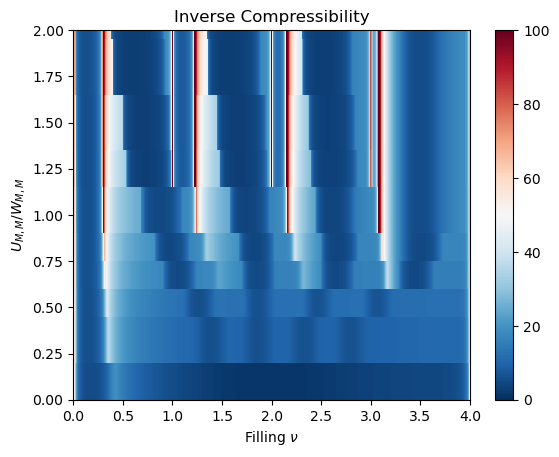

PyObject Text(0.5, 1.0, 'Inverse Compressibility')

In [15]:
PyPlot.svg(false)
pcolormesh(νs_interp, UmWm_ratio, dmudn_interp',vmin=0,vmax=100,cmap="RdBu_r")
cb = colorbar()
xlim(0,4)
ylim(0,2)

xlabel(L"Filling $\nu$")
ylabel(L"$U_{M,M}/W_{M,M}$")
title("Inverse Compressibility")

### Export in Matlab format for Y.X.

In [16]:
using MAT
δ=0.075
matwrite("supermore_model_Umm_Wmm_scan_data.mat", Dict(
    "W_sm" => df[!,:W2][1:1],
    "W_m" => df[!,:W1][1:1],
    "V_m_m" => df[!,:Umm],
    "V_m_sm" => df[!,:Umsm] .* δ,
    "V_sm_sm" => df[!,:Usmsm],
	"U_m_m" => df[!,:Umm],
    "U_m_sm" => df[!,:Umsm],
    "U_sm_sm" => df[!,:Usmsm],
	"nus_interpolated" => collect(νs_interp),
    "dmu_dn_interpolated" => dmudn_interp,
    "nus" => df[!,:nus_all],
    "nus_total" => df[!,:nus]
); compress = true)